# V1 (Past earnings reactions)


=== Exact Earnings Dates and Moves ===

Ticker: BIRK
  2024-Q1 | 2023-10-12 | Move: -9.50%
  2024-Q2 | 2024-01-18 | Move: -7.32%
  2024-Q2 | 2024-02-29 | Move: -6.64%
  2024-Q3 | 2024-05-30 | Move: 14.02%
  2024-Q4 | 2024-08-29 | Move: -17.79%
  2025-Q1 | 2024-12-18 | Move: 2.73%
  2025-Q2 | 2025-02-20 | Move: -5.28%
  2025-Q3 | 2025-05-15 | Move: 4.04%

Ticker: CROX
  2023-Q3 | 2023-04-27 | Move: -16.31%
  2023-Q4 | 2023-07-27 | Move: -9.73%
  2024-Q1 | 2023-11-02 | Move: -3.98%
  2024-Q2 | 2024-02-15 | Move: 9.79%
  2024-Q3 | 2024-05-07 | Move: 6.94%
  2024-Q4 | 2024-08-01 | Move: -8.23%
  2025-Q1 | 2024-10-29 | Move: -21.04%
  2025-Q2 | 2025-02-13 | Move: 22.06%
  2025-Q3 | 2025-05-08 | Move: 8.94%
  2025-Q3 | 2025-06-04 | Move: -1.96%

Ticker: DECK
  2023-Q3 | 2023-05-25 | Move: 5.64%
  2023-Q4 | 2023-07-27 | Move: -4.29%
  2024-Q1 | 2023-10-26 | Move: 17.05%
  2024-Q2 | 2024-02-01 | Move: 17.03%
  2024-Q3 | 2024-05-23 | Move: 15.67%
  2024-Q4 | 2024-07-25 | Move: 5.75%
  2024-Q4 

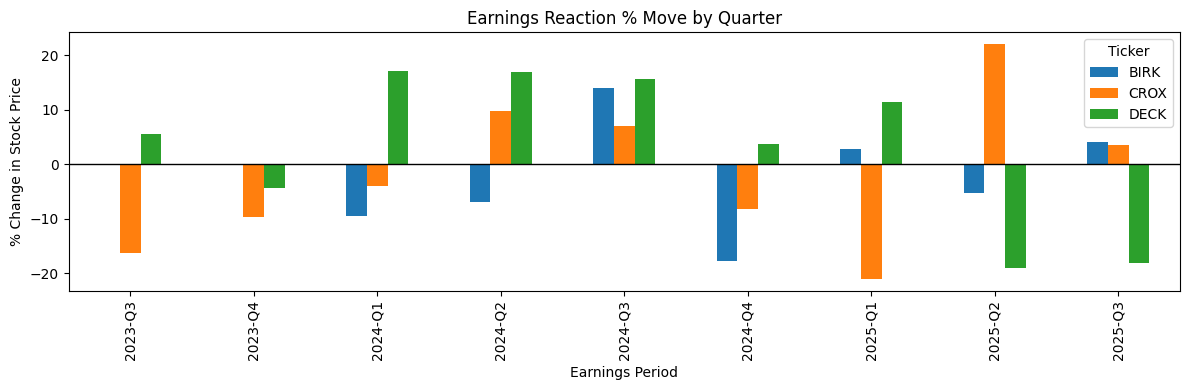

In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# retrieves earnings dates
def get_earnings_moves(ticker, limit=10):
    t = yf.Ticker(ticker)
    try:
        ed = t.get_earnings_dates(limit=40)
        if isinstance(ed, pd.DataFrame) and not ed.empty:
            ed = ed.reset_index()
            if 'startdatetime' in ed.columns:
                ed['date'] = pd.to_datetime(ed['startdatetime']).dt.date
            elif 'Earnings Date' in ed.columns:
                ed['date'] = pd.to_datetime(ed['Earnings Date']).dt.date
    except Exception:
        return pd.DataFrame(columns=["ticker", "earnings_date", "pct_move", "period"])

    if ed.empty:
        return pd.DataFrame(columns=["ticker", "earnings_date", "pct_move", "period"])

    ed_dates = sorted(list(set(pd.to_datetime(ed['date']).dt.date)), reverse=True)[:limit]
    ed_dates = sorted(ed_dates)

    start = pd.Timestamp(ed_dates[0]) - pd.Timedelta(days=14)
    end = pd.Timestamp(ed_dates[-1]) + pd.Timedelta(days=14)
    hist = t.history(
        start=start.strftime("%Y-%m-%d"),
        end=(pd.Timestamp.today() + pd.Timedelta(days=3)).strftime("%Y-%m-%d"),
        interval="1d"
    )

    # gets prices and calculates % change before and after earnings
    rows = []
    for d in ed_dates:
        prev_idx = hist.index[hist.index.date < d]
        next_idx = hist.index[hist.index.date > d]
        if prev_idx.empty or next_idx.empty:
            continue
        prev_close = float(hist.loc[prev_idx[-1]]['Close'])
        next_close = float(hist.loc[next_idx[0]]['Close'])
        pct = (next_close - prev_close) / prev_close * 100.0

        # labels X-axis with Quarter names instead of dates
        year = pd.Timestamp(d).year
        quarter = ((pd.Timestamp(d).month - 1) // 3) + 1
        if quarter == 4:
            period_label = f"{year + 1}-Q1"
        else:
            period_label = f"{year}-Q{quarter + 1}"

        rows.append({
            "ticker": ticker,
            "earnings_date": d,
            "period": period_label,
            "pct_move": pct
        })

    return pd.DataFrame(rows)

# *****CHANGE STOCK TICKERS HERE******
tickers = ["BIRK", "CROX", "DECK"]
all_moves = pd.DataFrame()

for tk in tickers:
    all_moves = pd.concat([all_moves, get_earnings_moves(tk, limit=10)], ignore_index=True)

# PRINT EXACT EARNINGS DATES AND MOVES
print("\n=== Exact Earnings Dates and Moves ===")
for ticker in tickers:
    sub = all_moves[all_moves["ticker"] == ticker].sort_values("earnings_date")
    print(f"\nTicker: {ticker}")
    for _, row in sub.iterrows():
        print(f"  {row['period']} | {row['earnings_date']} | Move: {row['pct_move']:.2f}%")

# Aggregate to handle duplicates
agg_df = (
    all_moves.groupby(["period", "ticker"], as_index=False)["pct_move"]
    .mean()
)

# Pivot for plotting
pivot_df = agg_df.pivot(index="period", columns="ticker", values="pct_move").sort_index()

# Plot grouped bar chart
pivot_df.plot(kind="bar", figsize=(12,4))
plt.title("Earnings Reaction % Move by Quarter")
plt.ylabel("% Change in Stock Price")
plt.xlabel("Earnings Period")
plt.axhline(0, color="black", linewidth=1)
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()


# V2 (within 10 days earnings)

Wanted to see how stock price changed within 10 days of earnings to get the bigger picture

/var/folders/v0/76lrzcs938l54rkbd25b881r0000gn/T/ipykernel_13812/625501478.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/v0/76lrzcs938l54rkbd25b881r0000gn/T/ipykernel_13812/625501478.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Earnings Dates:
Ticker Earnings Date  Days from Trigger
  BIRK    2025-05-15                 20
  DECK    2025-05-22                 13
  CROX    2025-06-04                  0
   NKE    2025-06-26                 22



/var/folders/v0/76lrzcs938l54rkbd25b881r0000gn/T/ipykernel_13812/625501478.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/v0/76lrzcs938l54rkbd25b881r0000gn/T/ipykernel_13812/625501478.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


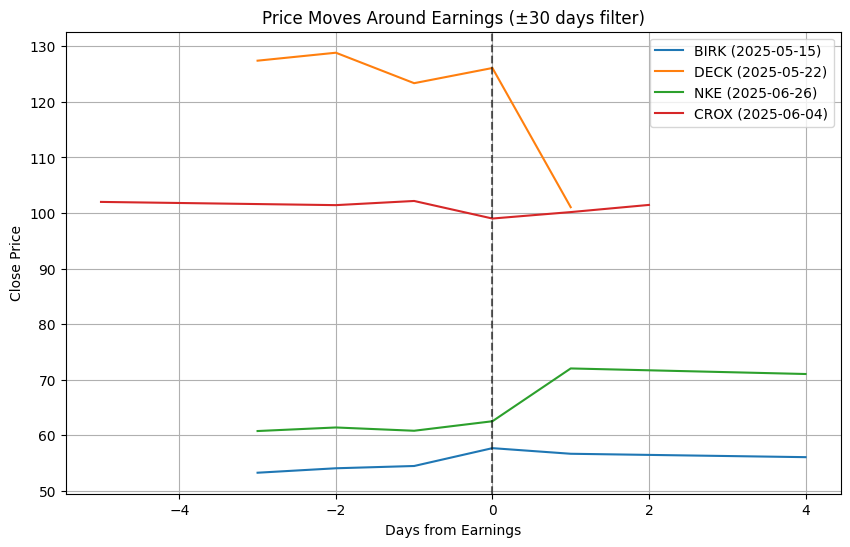

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# INPUT STOCK TICKERS HERE
trigger_ticker = "CROX"  # the company that just reported
peer_tickers = ["BIRK", "DECK", "NKE"]  # comps. in same industry
window_days = 30  # earnings date must be within ± this many days of trigger

# gets last earnings date
def get_last_earnings_date(ticker):
    stock = yf.Ticker(ticker)
    cal = stock.get_earnings_dates(limit=1)  # most recent earnings
    if cal is None or cal.empty:
        return None
    return cal.index[0].date()

# gets price history around earnings
def get_price_window(ticker, earnings_date, days_before=5, days_after=5):
    start = earnings_date - timedelta(days=days_before)
    end = earnings_date + timedelta(days=days_after)
    df = yf.download(ticker, start=start, end=end)
    return df['Close']

trigger_date = get_last_earnings_date(trigger_ticker)
if not trigger_date:
    raise ValueError(f"No earnings found for {trigger_ticker}")

# filter competitors
dates_table = []
valid_peers = []

for t in peer_tickers:
    edate = get_last_earnings_date(t)
    if not edate:
        continue
    diff = abs((edate - trigger_date).days)
    dates_table.append({"Ticker": t, "Earnings Date": edate, "Days from Trigger": diff})
    if diff <= window_days:
        valid_peers.append((t, edate))

dates_table.append({"Ticker": trigger_ticker, "Earnings Date": trigger_date, "Days from Trigger": 0})
valid_peers.append((trigger_ticker, trigger_date))

# prints dates table
dates_df = pd.DataFrame(dates_table).sort_values("Earnings Date")
print("\nEarnings Dates:")
print(dates_df.to_string(index=False))

# plot
plt.figure(figsize=(10, 6))
for t, edate in valid_peers:
    prices = get_price_window(t, edate)
    rel_days = (prices.index.date - edate)
    rel_days = [(d - edate).days for d in prices.index.date]
    plt.plot(rel_days, prices.values, label=f"{t} ({edate})")

plt.axvline(0, color='k', linestyle='--', alpha=0.6)  # earnings day line
plt.title(f"Price Moves Around Earnings (±{window_days} days filter)")
plt.xlabel("Days from Earnings")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
